# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

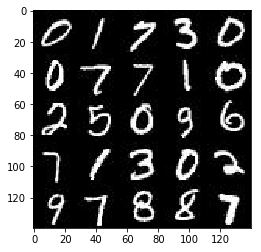

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

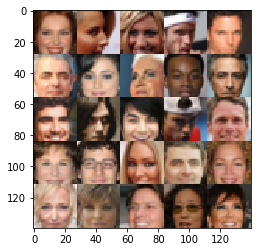

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input lyaer: 28x28x3 
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         print('x1.shape:', x1.shape)
        # 4x4x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print('x2.shape:', x2.shape)
        # 8x8x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         print('x3.shape:', x3.shape)
        # 16x16x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
#         print('logits.shape:', logits.shape)
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               in_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, 
                                               in_learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.7459... Generator Loss: 0.0287
Epoch 1/2... Discriminator Loss: 0.4874... Generator Loss: 4.9297
Epoch 1/2... Discriminator Loss: 0.2789... Generator Loss: 1.7115
Epoch 1/2... Discriminator Loss: 1.7300... Generator Loss: 1.8914
Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 2.3594


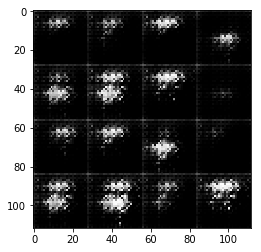

Epoch 1/2... Discriminator Loss: 0.2589... Generator Loss: 3.5064
Epoch 1/2... Discriminator Loss: 0.2287... Generator Loss: 4.1565
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 0.1714... Generator Loss: 3.8153
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 5.7512


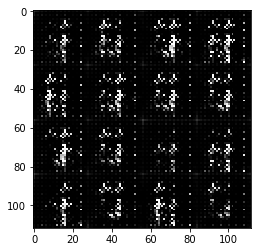

Epoch 1/2... Discriminator Loss: 0.4240... Generator Loss: 9.2209
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.4649
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 1.1177
Epoch 1/2... Discriminator Loss: 0.1261... Generator Loss: 4.9620
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.8348


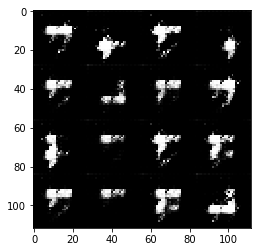

Epoch 1/2... Discriminator Loss: 0.1515... Generator Loss: 3.0001
Epoch 1/2... Discriminator Loss: 0.1936... Generator Loss: 2.4366
Epoch 1/2... Discriminator Loss: 0.1397... Generator Loss: 3.6401
Epoch 1/2... Discriminator Loss: 0.4361... Generator Loss: 1.9184
Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 1.7269


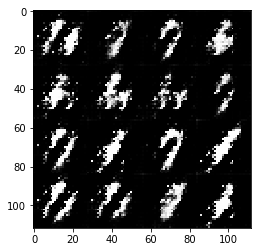

Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 0.7032... Generator Loss: 7.2636
Epoch 1/2... Discriminator Loss: 0.5027... Generator Loss: 4.0084
Epoch 1/2... Discriminator Loss: 0.5800... Generator Loss: 4.0383
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.9330


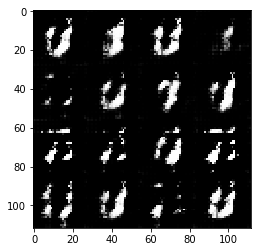

Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 6.4793
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 1.5884
Epoch 1/2... Discriminator Loss: 0.2813... Generator Loss: 2.3176
Epoch 1/2... Discriminator Loss: 0.4855... Generator Loss: 1.6865
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 5.9488


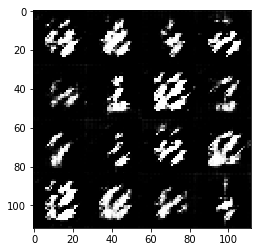

Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 2.1949
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 1.5626
Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.8406
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 1.5967
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 2.5447


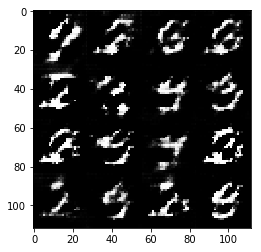

Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 2.8136
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 2.0202
Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 1.6256
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 2.1522
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 2.7826


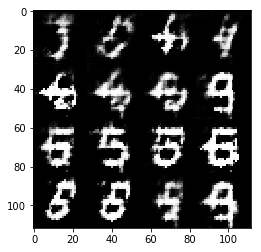

Epoch 1/2... Discriminator Loss: 0.7542... Generator Loss: 1.2876
Epoch 1/2... Discriminator Loss: 0.6078... Generator Loss: 1.4823
Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 1.3897
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.8634... Generator Loss: 1.3247


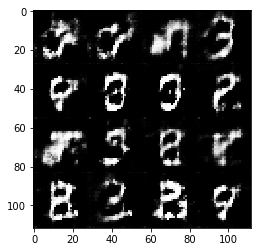

Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 0.4676
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 3.0293
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.6372
Epoch 1/2... Discriminator Loss: 0.6543... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.0106


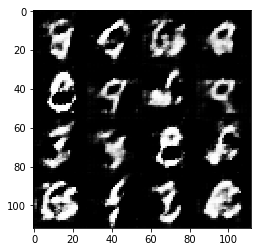

Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.6053
Epoch 1/2... Discriminator Loss: 0.7279... Generator Loss: 1.4571
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.6917
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 2.9533
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 2.5176


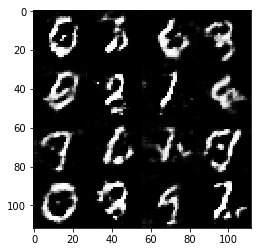

Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 2.0093
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.4806
Epoch 1/2... Discriminator Loss: 0.8669... Generator Loss: 1.4478
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 1.9847


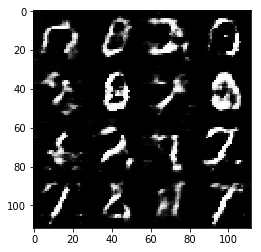

Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 3.9620
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 2.1467
Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 3.5091


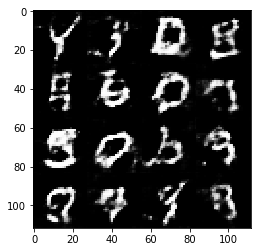

Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.3020
Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 0.7629... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.5329


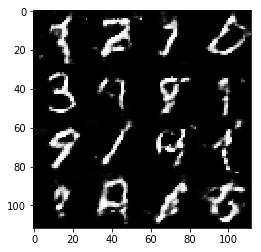

Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.4433
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 1.1488
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 3.3974
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 0.7260


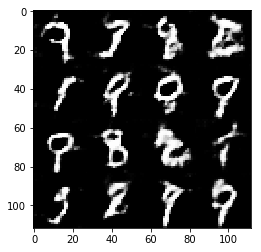

Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 1.4004
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 0.9235
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 2.0100
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 2.4568


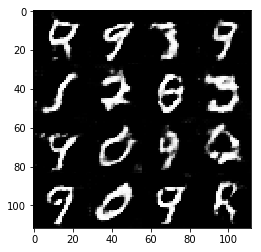

Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 1.8871


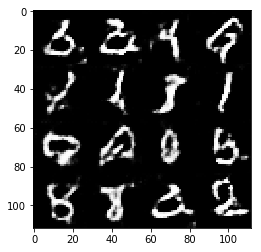

Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 2.0881
Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 2.1097... Generator Loss: 0.2139
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 0.7439


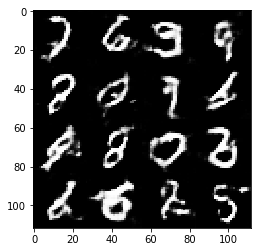

Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.6161


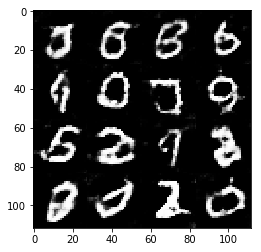

Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 3.6566... Generator Loss: 0.0562
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 0.9035


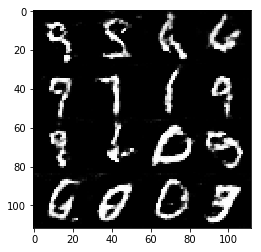

Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 1.7679
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.9386
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.6200


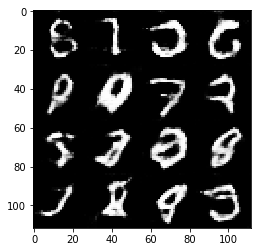

Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.6584
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 2.8658
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.5784


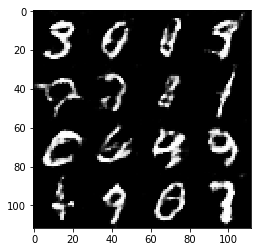

Epoch 2/2... Discriminator Loss: 1.6055... Generator Loss: 3.0564
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 2.2301
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.4549


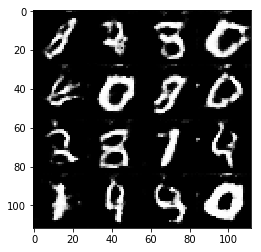

Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 1.1255
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.8039


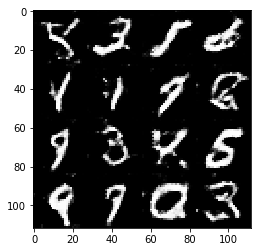

Epoch 2/2... Discriminator Loss: 2.6692... Generator Loss: 4.8516
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.4377
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 2.3036... Generator Loss: 0.1823
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 1.6671


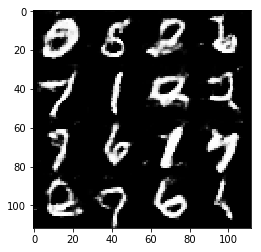

Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 0.7798
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.3518
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 0.8367


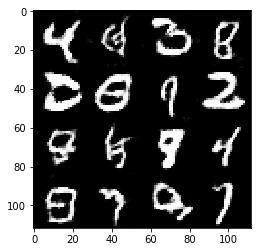

Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.3735
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.9001
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.1877
Epoch 2/2... Discriminator Loss: 1.8118... Generator Loss: 0.2977
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.2919


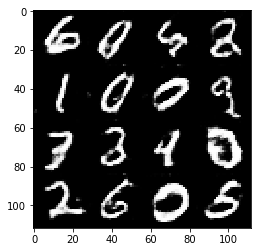

Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.5516
Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.7299


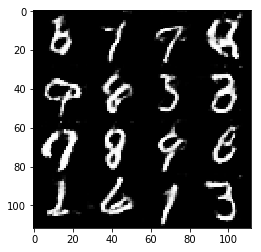

Epoch 2/2... Discriminator Loss: 1.5075... Generator Loss: 0.3527
Epoch 2/2... Discriminator Loss: 0.8842... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 2.1350... Generator Loss: 0.2129
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.7176


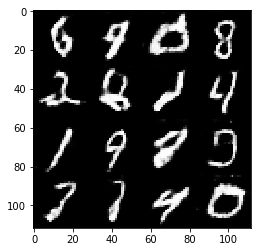

Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 2.2580
Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.9297
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 0.8190
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.3033


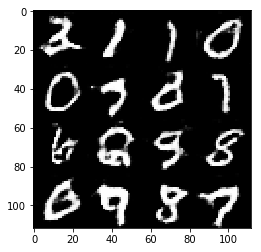

Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 1.7503... Generator Loss: 2.4313
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.4993
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 0.7909


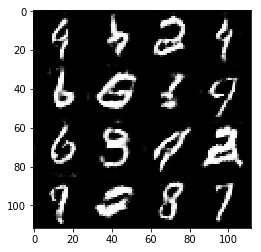

Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.5041
Epoch 2/2... Discriminator Loss: 0.8472... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 2.4464... Generator Loss: 0.1444


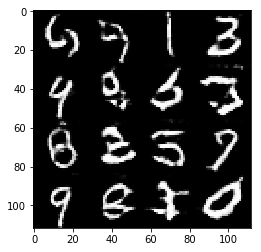

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 0.9476
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.4047
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 0.8924


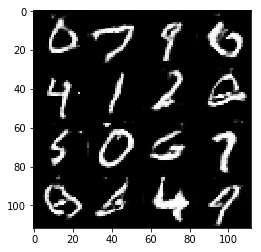

Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 1.7431
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.5316


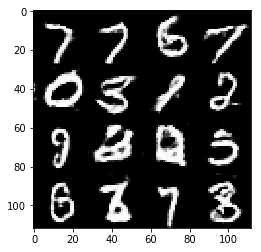

Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.3093
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 2.1219
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.4925


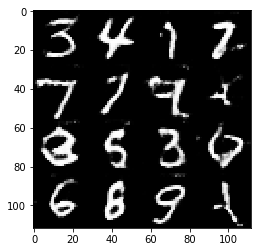

Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.7818
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.6996
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 0.8413


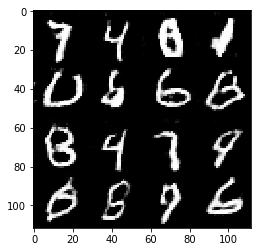

Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 1.7380
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.6801
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.1661
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 3.0255
Epoch 2/2... Discriminator Loss: 0.6381... Generator Loss: 2.1477


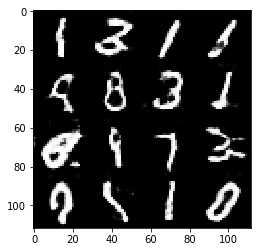

Epoch 2/2... Discriminator Loss: 0.7743... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 1.2922


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3176... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 9.6117
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 14.3519
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 16.1507
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 5.8588


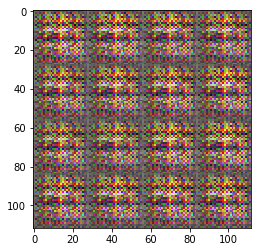

Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 13.4790
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.8104... Generator Loss: 7.6109
Epoch 1/1... Discriminator Loss: 1.8935... Generator Loss: 0.5070


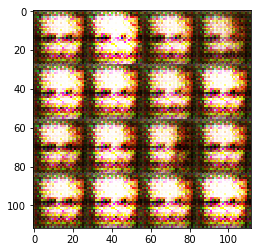

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 5.6015
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 3.0636
Epoch 1/1... Discriminator Loss: 0.0953... Generator Loss: 2.9684
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 5.7237


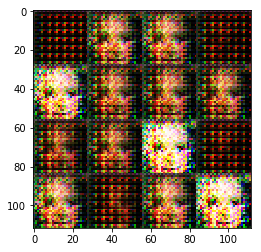

Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 1.7850
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 6.9225
Epoch 1/1... Discriminator Loss: 2.0972... Generator Loss: 0.1734
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9666


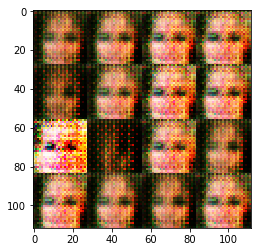

Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 0.3144... Generator Loss: 4.3866
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 4.9684
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.4360


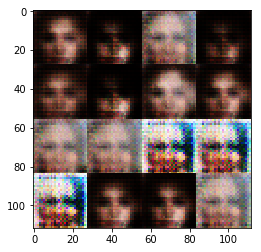

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 0.2320... Generator Loss: 3.0159
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.3514


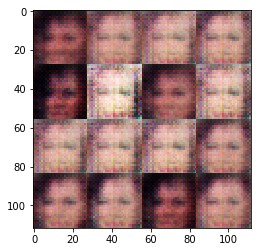

Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8615


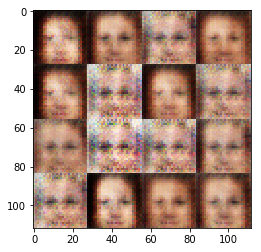

Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 2.4000
Epoch 1/1... Discriminator Loss: 1.7050... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1582


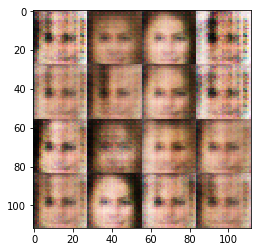

Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 1.5685


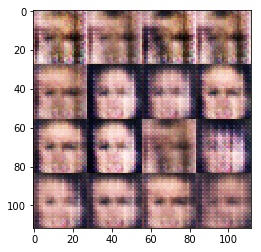

Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 2.4181
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.3753


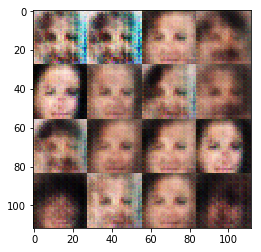

Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.8969
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.7313


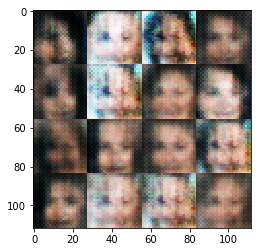

Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.7717
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 3.0486


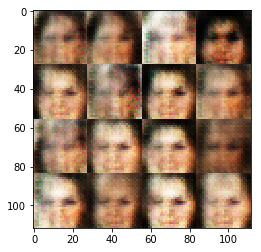

Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.8274
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 3.5179
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.9561


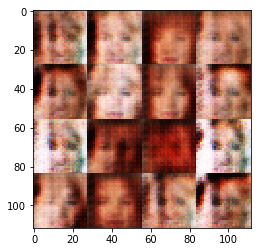

Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 3.4968
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.3803


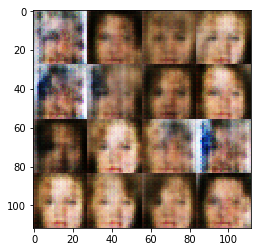

Epoch 1/1... Discriminator Loss: 2.6590... Generator Loss: 0.1059
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.0776
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 0.8563


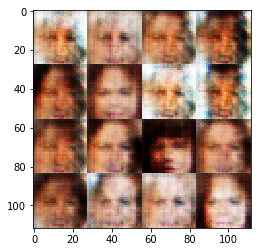

Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.7838
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 2.3006
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 2.6784
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.4443


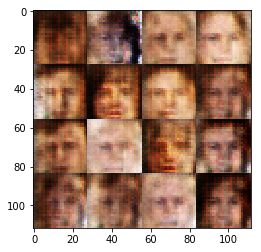

Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.9040


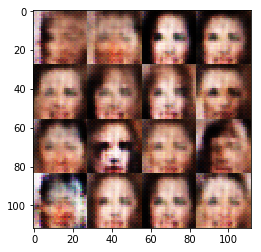

Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 2.9809
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.8997... Generator Loss: 2.8815
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 1.1885


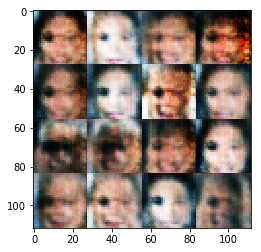

Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.8305


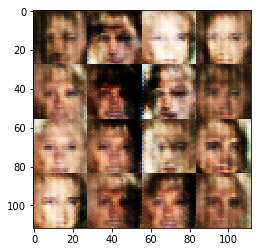

Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6438


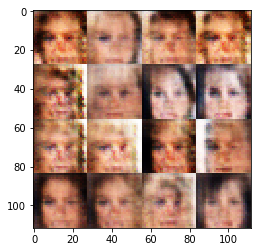

Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 3.0510... Generator Loss: 4.0888
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.5382


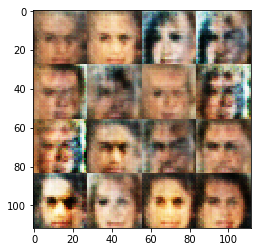

Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 3.1958


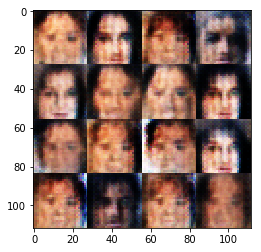

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.2752


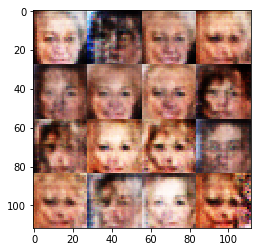

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.5475
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 1.0788


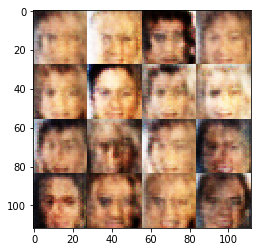

Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.6304
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9118


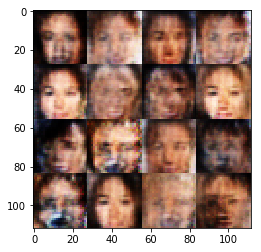

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.4982
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 0.8970


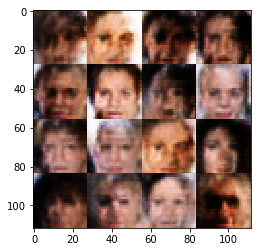

Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1351


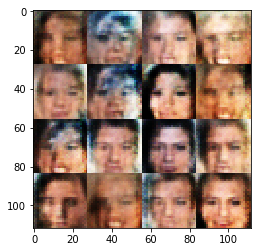

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 2.0666
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4642


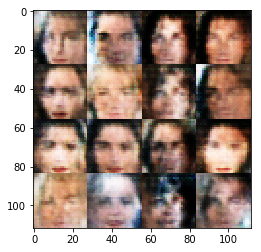

Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.6031


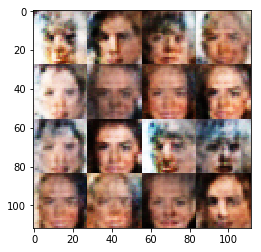

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.4791


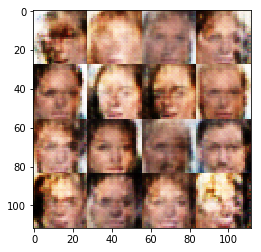

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.4617


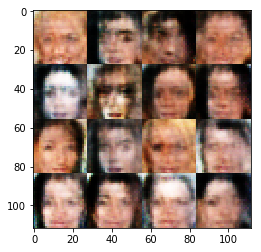

Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.6793
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9071


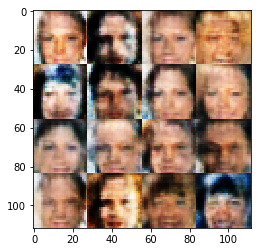

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.8025
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.5871


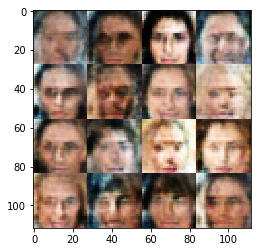

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 1.6271
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.3426


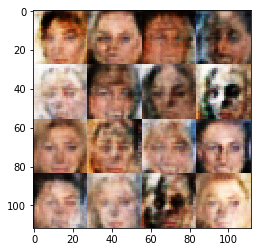

Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.0804


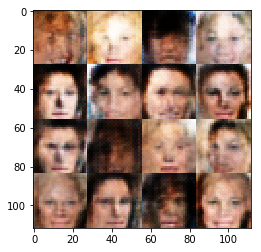

Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.0165


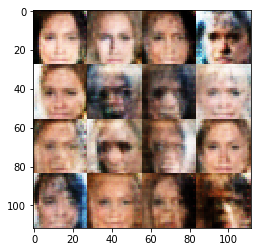

Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.0970


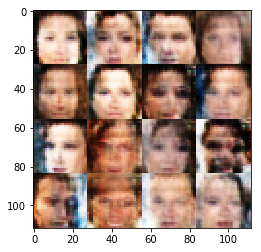

Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 1.8314... Generator Loss: 0.2279
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.4098


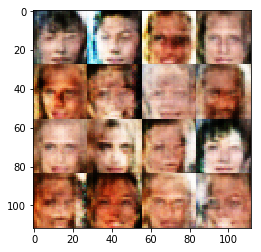

Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.3726


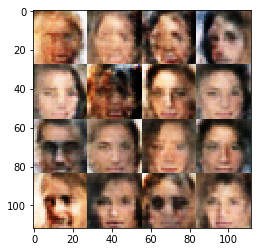

Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6389


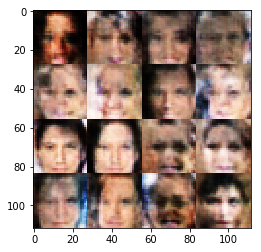

Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.7501
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.1559


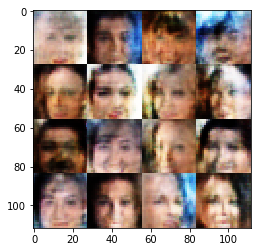

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.7856


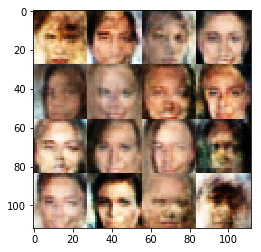

Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.4392


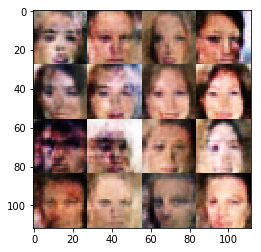

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5373


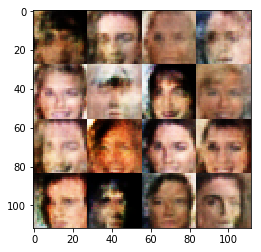

Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.5784


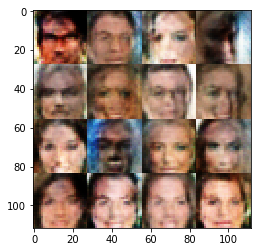

Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 2.5706
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.3103


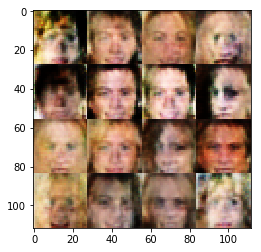

Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.0785


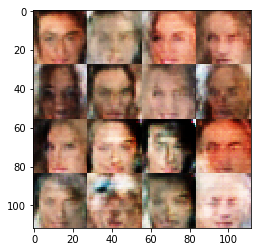

Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.4075


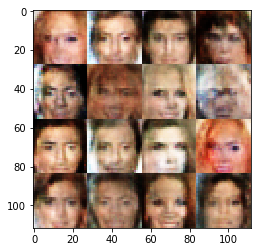

Epoch 1/1... Discriminator Loss: 1.9764... Generator Loss: 0.2230
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.5463


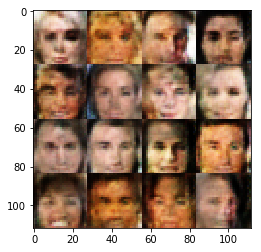

Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7363


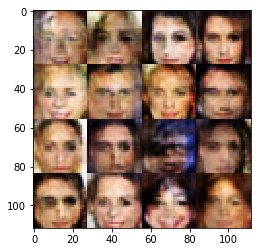

Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 2.6205


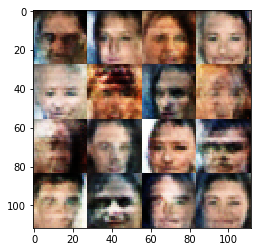

Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.9179
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.7259


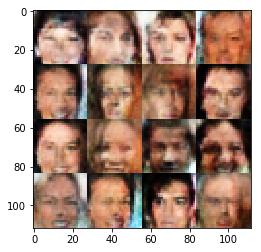

Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 2.1676
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.2702


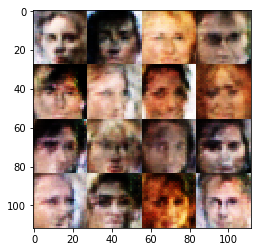

Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 2.7504
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.9621


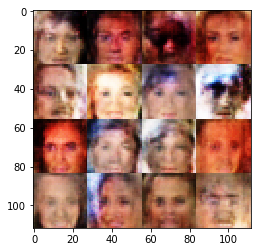

Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.2576


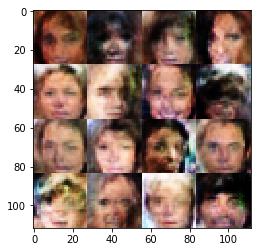

Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.3031


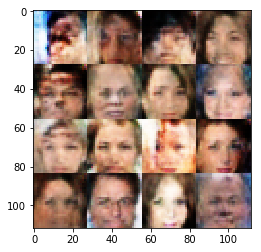

Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.5900
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.7758
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.4861


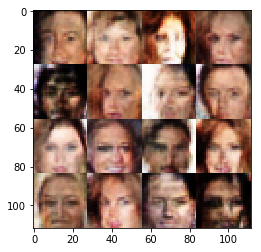

Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0128


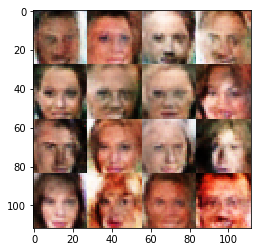

Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.6802
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.1132


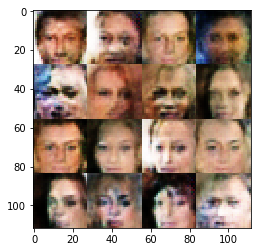

Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 2.1065
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.9030


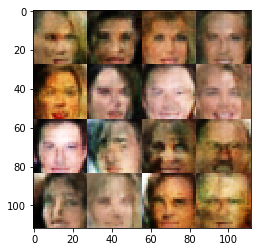

Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9389


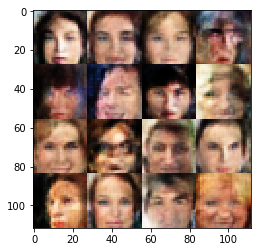

Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 2.5961
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.4883


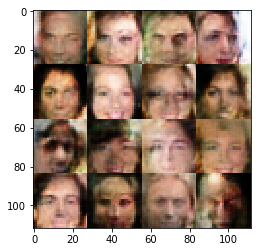

Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.2937
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 0.9035


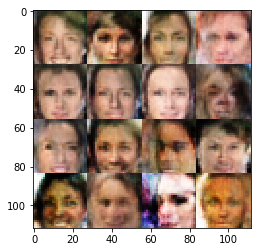

Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.5284


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.